In [11]:
import numpy as np
import matplotlib.pyplot as plt

## Simple quantum-bit transformation to bloch coordinate

In [12]:
zero = np.array([1, 0])
one = np.array([0, 1])

In [13]:
a = 1 + 0j
b = 0 + 1j

# normalize the vectors
r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)

a = a / r
b = b / r

psi = a * zero + b * one
psi

array([0.70710678+0.j        , 0.        +0.70710678j])

In [14]:
phi_a = np.angle(a)
phi_b = np.angle(b)
r_a = np.abs(a)
r_b = np.abs(b)

phi = phi_b - phi_a
theta = 2 * np.arccos(r_a)

psi_bloch = np.cos(theta / 2) * zero + np.exp(1j * phi) * np.sin(theta / 2) * one

assert np.allclose(psi, psi_bloch), "Calculations are wrong"

psi_bloch

array([7.07106781e-01+0.j        , 4.32978028e-17+0.70710678j])

In [15]:
def convert_to_bloch(psi: np.ndarray):
    a = psi[0]
    b = psi[1]
    phi_a = np.angle(a)
    phi_b = np.angle(b)
    r_a = np.abs(a)
    r_b = np.abs(b)
    phi = phi_b - phi_a
    theta = 2 * np.arccos(r_a)
    if np.isnan(theta):
        theta = 2 * np.arcsin(r_b)
    return np.array([theta / 2, phi])

In [16]:
def qubit_to_cartesian(qubit: np.ndarray):
    # map a qubit to spherical coordinates
    return np.array(
        [
            2 * np.real(qubit[1] * np.conj(qubit[0])),
            2 * np.imag(qubit[1] * np.conj(qubit[0])),
            np.abs(qubit[0]) ** 2 - np.abs(qubit[1]) ** 2,
        ]
    )

In [81]:
class Gate:
    """
    A class to represent a quantum gate. It is represented by a unitary matrix.
    """

    def __init__(self, matrix: np.ndarray):

        assert matrix.shape[0] == 2 and matrix.shape[1] == 2, "The matrix must be 2x2"
        assert np.allclose(
            np.eye(2), matrix @ matrix.conj().T
        ), "The matrix is not unitary"

        self.matrix = matrix

    @property
    def U(self):
        return self.matrix

    def apply(self, state: np.ndarray):
        """Apply the gate to a state. The state is a column vector of size 2, where the first element is the amplitude of |0> and the second element is the amplitude of |1>.

        Args:
            state (np.ndarray): The state to apply the gate to.

        Returns:
            np.ndarray: The new state after applying the gate.
        """
        return self.matrix @ state

    @property
    def rotation_axis(self):
        """Return the axis of rotation of the gate in the Bloch sphere.

        Returns:
            np.ndarray: The axis of rotation.
        """

        eigenvalues, eigenvectors = np.linalg.eig(self.matrix)

        a = eigenvectors[:, 0][0]
        b = eigenvectors[:, 0][1]
        c = eigenvectors[:, 1][0]
        d = eigenvectors[:, 1][1]

        off_diagonal = c * np.conj(d) - a * np.conj(b)
        x = np.real(off_diagonal)
        y = -1 * np.imag(off_diagonal)
        z = np.abs(c) ** 2 - np.abs(a) ** 2

        rotation_angle = np.angle(eigenvalues[0]) - np.angle(eigenvalues[1])

        return np.array([x, y, z])

    @property
    def rotation_angle(self):
        """Return the angle of rotation of the gate in the Bloch sphere.

        Returns:
            float: The angle of rotation.
        """

        eigenvalues, eigenvectors = np.linalg.eig(self.matrix)
        return np.angle(eigenvalues[0]) - np.angle(eigenvalues[1])

    @staticmethod
    def from_rotation(axis: np.ndarray, angle: float):
        """Create a gate that represents a rotation around an axis.

        Args:
            axis (np.ndarray): The axis of rotation.
            angle (float): The angle of rotation.

        Returns:
            Gate: The gate that represents the rotation.
        """

        x, y, z = axis

        # normalize the axis
        axis = axis / np.linalg.norm(axis)

        # create the rotation matrix

        # the rotation matrix is given by the formula R = exp(-i * angle * axis dot sigma / 2)
        # where sigma is the vector of Pauli matrices

        # the dot product of the axis with the Pauli matrices

        sigma = np.array(
            [
                np.array([[0, 1], [1, 0]]),
                np.array([[0, -1j], [1j, 0]]),
                np.array([[1, 0], [0, -1]]),
            ]
        )

        return Gate(
            np.cos(angle / 2) * np.eye(2)
            - 1j * np.sin(angle / 2) * (x * sigma[0] + y * sigma[1] + z * sigma[2])
        )

    def __repr__(self) -> str:
        if np.allclose(self.U, np.eye(2)):
            return "I"
        if np.allclose(self.U, np.array([[0, 1], [1, 0]])):
            return "X"
        if np.allclose(self.U, np.array([[0, -1j], [1j, 0]])):
            return "Y"
        if np.allclose(self.U, np.array([[1, 0], [0, -1]])):
            return "Z"
        return f"U({self.U})"

In [82]:
def cartesian_to_polar(vector):

    [x, y, z] = vector

    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return np.array([theta, phi, r])

In [83]:
X_gate = Gate(np.array([[0, 1], [1, 0]]))
Y_gate = Gate(np.array([[0, -1j], [1j, 0]]))
Z_gate = Gate(np.array([[1, 0], [0, -1]]))
H_gate = Gate(1 / np.sqrt(2) * np.array([[1, 1], [1, -1]]))

In [84]:
def calculate_trajectory(gate: Gate, state_from: np.ndarray, n_points: int):
    """Calculates the trajectory of a gate applied to a state in the Bloch sphere.

    Args:
        gate (Gate): The gate to apply.
        state_from (np.ndarray): The starting state.
        n_points (int): The number of points to calculate.

    Returns:
        np.ndarray: The points in the Bloch sphere. Each column is a point in Cartesian coordinates.
    """

    t = np.linspace(0, gate.rotation_angle, n_points)

    points = list(
        map(
            qubit_to_cartesian,
            [Gate.from_rotation(gate.rotation_axis, _t).apply(state_from) for _t in t],
        )
    )

    return np.array(points).T

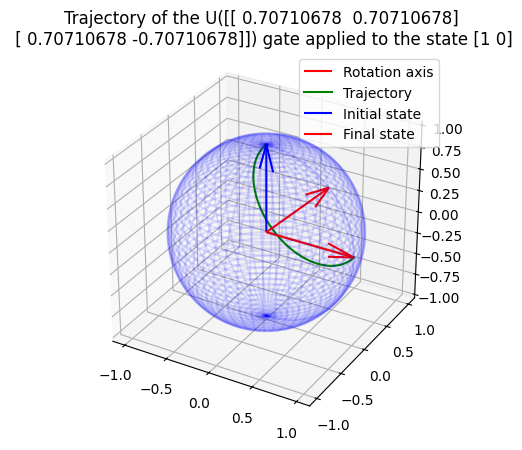

In [87]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# plot the bloch sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color="b", alpha=0.1)

gate = H_gate
state_from = zero
p_from = qubit_to_cartesian(state_from)
p_to = qubit_to_cartesian(gate.apply(state_from))

# plot the rotation axis of the X gate
ax.quiver(0, 0, 0, *(-gate.rotation_axis), color="r", label="Rotation axis")

# draw the path with center axis being the rotation axis and angle being the rotation angle

[x, y, z] = calculate_trajectory(gate, state_from, 100)

ax.plot(x, y, z, color="g", label="Trajectory")

ax.quiver(0, 0, 0, *p_from, color="b", label="Initial state")
ax.quiver(0, 0, 0, *p_to, color="r", label="Final state")

ax.set_aspect("equal")
ax.legend()

plt.title(f"Trajectory of the {gate} gate applied to the state {state_from}")

plt.show()